In [1]:
# By Bart Ouwehand 12-04-2022
import numpy as np
import matplotlib.pyplot as plt

import h5py
import scipy.signal
import logging
import time
import multiprocess
import os

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument
from lisaconstants import c


from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho
from pytdi.dsp import timeshift

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import BarycentricMeanEcliptic

from tqdm import tqdm

# Import own functions
from my_functions import *


orbit_path = '../orbits/esa-orbits.h5'
gw_path = 'gws.h5'

# Setup simluation parameters
# fs = 0.1    # Hz
fs = 0.05    # Hz
day = 86400 # s
duration = day*180 # X days
size = duration*fs
# size = 4000
discard = 300
rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")

# Turn on/off binary creation & instrument simulation
use_verbinaries = True
run_new_simulation = False
gen_plots = False


# Specify specific number of binaries
Ngalbins = 16


Number of Verification Binaries = 16
fs = 0.05 Hz,  orbit_duration = 1424.0 d


In [2]:
plt.style.use('style.mplstyle')
cols = ['red','red','blue','blue']
lnstls = ['-','--','-','--']

In [3]:
import pytdi
print(pytdi.__version__)
import lisainstrument
print (lisainstrument.__version__)

1.1
1.0.3


In [4]:
# Insert binary parameters
amplitude_amplification = 1

if use_verbinaries:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/sampdat_'+str(duration//day)+'d'+'_verbins' #extention of .h5 or .txt added later
    
    rawdata = ascii.read("verbinaries_data_wsource_name.txt")
    
    params = ['lGal', 'bGal', 'orbital_period', 'm1', 'm1e', 'm2', 'm2e', 'i', 'freq', 'par','epar', 'dis', 'edis', 'A', 'eA', 'SNR', 'eSNR']
    # units: lGal [deg], bGal [deg], orbital_period [s], m1 [Msol], m1e [Msol], m2 [Msol], m2e [Msol]
    # i [deg], freq (of gws) [mHz], par [mas], epar [mas], dis [pc], edis [pc], A [1e-23], eA [1e-23], SNR, eSNR
    
    sourcenames = np.array(rawdata["source"])[:Ngalbins]
    Amp_true = (np.array(rawdata["A"])* (1e-23 * amplitude_amplification))[:Ngalbins] # 10yokto to 1e-23 
    f_true = (np.array(rawdata["freq"])* (1e-3))[:Ngalbins] # mHz to Hz
    iota_true = np.deg2rad(np.array(rawdata["i"]))[:Ngalbins] # deg to rad
    
    # Import the SNR of the verification binaries
    SNR_verbins = np.array(rawdata["SNR"])
    SNRe_verbins = np.array(rawdata["eSNR"])
    
    # Galactic coordinates of verification binaries   
    source_gal_lon = np.array(rawdata["lGal"])[:Ngalbins]  # degree range from [0,360]
    source_gal_lat = np.array(rawdata["bGal"])[:Ngalbins]  # degree range from [-90,90]

    # Transform coordinates to (barycentric mean) ecliptic coordinates
    gc = SkyCoord(l=source_gal_lon*u.degree, b=source_gal_lat*u.degree, frame='galactic')
    gw_beta_true = np.deg2rad(gc.barycentricmeanecliptic.lon.value)[:Ngalbins] # degree to rad range [0,2pi]
    gw_lambda_true = np.deg2rad(gc.barycentricmeanecliptic.lat.value)[:Ngalbins] # degree to rad range [-pi/2,pi/2]

    # Transform coordinates to equatoral (ICRS) coordinates
    # ra = gc.icrs.ra.value # degree range [0,360]
    # dec = gc.icrs.dec.value # degree range [-90,90]
    
    totNgalbins = len(sourcenames)
    phi0_true_forinst = np.zeros(Ngalbins)
    phi0_true = np.array(ascii.read("verbinaries_phaseoffset_"+str(int(1/fs))+"dt.txt")['phi0'])[:Ngalbins]
    print ("Number of Verification Binaries = {}".format(Ngalbins))

else:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/MCMCsample'+str(int(duration))+'s' #extention of .h5 or .txt added later
    
    totNgalbins = 2
    Amp_true = np.array([1e-16,5e-13])[:Ngalbins]
    f_true = np.array([1e-3,1e-4])[:Ngalbins]
    
    phi0_true_forinst = np.zeros(Ngalbins)
    phi0_true = np.array([-0.4,0.2])[:Ngalbins]
    gw_beta_true = np.array([0,0])[:Ngalbins]
    gw_lambda_true = np.array([0,np.pi])[:Ngalbins]

Number of Verification Binaries = 16


In [5]:
# Define perfect model
def model(Afunc,Efunc,s,Amp=Amp_true[0], phi0=phi0_true[0], freq=f_true[0], gw_beta=gw_beta_true[0], gw_lambda=gw_lambda_true[0],iota=iota_true[0], t0=orbits_t0+1/fs):
    
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
    # Amp, phi0 = theta[0:Ngalbins], theta[Ngalbins:2*Ngalbins]
    
    # Generate GW signals
    #for a, f, p, beta, lamb in zip(Amp, freq, phi0, gw_beta, gw_lambda):
    GalBin = GalacticBinary(A=Amp/freq, f=freq, phi0=phi0, orbits=orbit_path, t0=t0, gw_beta=gw_beta, gw_lambda=gw_lambda,iota=iota, dt=1/fs, size=s+300)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
    GalBin.write(gwfn)
    
    discard = 300
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    mE = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    # time_indices = np.where(np.in1d(nmt, st))[0]
    # nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    
    return np.array([nmt,nmA,nmE])
    # return np.array([t,A,E,T])


from lisainstrument.containers import ForEachMOSA, ForEachSC

class testInstrument(Instrument):
    def __init__(self, **kw):
        super().__init__( laser_asds=0, 
                          modulation_asds=0,
                          aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
                          oms_asds =(15e-12, 1.25e-11, 1.42e-12, 3.38e-12, 3.32e-12, 7.9e-12),
                          testmass_asds = 3e-15,
                          lock='six', orbits='static', **kw)
        
        self.disable_clock_noises()
        self.disable_all_noises()

        
    def init_orbits(self, orbits, orbit_dataset, tau=2.5e9/c):
       
        if orbits == 'static':
            # logger.info(f"Using default set of static proper pseudo-ranges L/c={tau}")
            self.orbit_file = None
            self.pprs = ForEachMOSA({
                # Default PPRs based on first samples of Keplerian orbits (v1.0)
                '12': tau, '23': tau, '31': tau,
                '13': tau, '32': tau, '21': tau,
            })
            self.d_pprs = ForEachMOSA(0)
            self.tps_proper_time_deviations = ForEachSC(0)
            self.orbit_dataset = None
        else:
            super().init_orbit(orbits, orbit_dataset )

def model2(Afunc,Efunc,s, Amp=1, phi0=phi0_true[0], freq=f_true[0], gw_beta=gw_beta_true[0], gw_lambda=gw_lambda_true[0], iota=iota_true[0], t0=orbits_t0+1/fs):
    
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
    GalBin = GalacticBinary(A=Amp, f=freq, phi0=phi0, orbits=orbit_path, t0=t0, gw_beta=gw_beta, gw_lambda=gw_lambda,iota=iota, dt=1/fs, size=s+300)
    GalBin.write(gwfn)
    
    Instrument = testInstrument(dt=1/fs, size=s+300,gws=gwfn,t0=orbits_t0)
    
    Instrument.simulate()
    # Instrument.write(mode='w')
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_instrument(Instrument)#,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    mE = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    # time_indices = np.where(np.in1d(nmt, st))[0]
    # nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    
    return np.array([nmt,nmA,nmE])
    # return np.array([t,A,E,T])
    


In [6]:
# Generate A and E chanel for perfect model
if run_new_simulation:
    if os.path.exists('gwtmp.h5'):
        os.remove('gwtmp.h5')
    source = GalacticBinary(A=1, f=f_true[0], phi0=phi0_true[0], orbits=orbit_path,
                            t0=orbits_t0 + 10, gw_beta=gw_beta_true[0], gw_lambda=gw_lambda_true[0],iota=iota_true[0],
                            dt=1/fs, size=size+300)
    source.write('gwtmp.h5')
    # tmp_instru = testInstrument(dt=1/fs, size=size+300,gws='gwtmp.h5')
    # tmp_instru.simulate()
    # rawdata = Data.from_instrument(tmp_instru)
    rawdata =Data.from_gws('gwtmp.h5', orbit_path,interpolate=True)
    print ("Begin A build")
    Afunc = ortho.A2.build(**rawdata.args)
    print ("Begin E build")
    Efunc = ortho.E2.build(**rawdata.args)
    os.remove('gwtmp.h5')
    print ("Finished")

In [7]:
# Define psd function
def psd_func(data):
    return np.array(scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False))

# Define FFT functions
def FFT(A):
    from numpy.fft import fft, fftshift, ifft, ifftshift
    fourierA = fftshift(fft(A))
    return fourierA

def IFFT(fourierA):
    from numpy.fft import fft, fftshift, ifft, ifftshift
    A = ifft(ifftshift(fourierA))
    return A

def make_psd(data):
    tmp = []
    for i in range(1,3):
        psdtmp = psd_func(data[i])
        tmp.append(psdtmp[1])
    psd = np.array([psdtmp[0],*tmp])
    return psd

def make_fft(data):
    tmp = []
    fft_freq = np.fft.fftshift(np.fft.fftfreq(len(data[1]), d=1/fs))
    fft_freq = fft_freq[len(fft_freq)//2:]
    for i in range(1,3):
        ffttmp = FFT(data[i])
        tmp.append(ffttmp[len(ffttmp)//2:])
    fft = np.array([fft_freq, *tmp])
    return fft[:,1:]

In [8]:
if run_new_simulation:
    # Define analytical noise PSD
    mdata = model(Afunc,Efunc,size)
    print (mdata.shape)

    psd = make_psd(mdata)
    fft = make_fft(mdata)

    rec = ['A','E']

    fig,axs = plt.subplots(1,2,figsize=(10,4))
    for i in range(2):
        axs[i].plot(mdata[0]/day,mdata[i+1])
        axs[i].set_title(rec[i])
        # axs[i].set_xlim(.5,.55)
    plt.show()


    plt.figure(figsize=(8,4))
    for i in range(1,3):
        plt.loglog(psd[0],psd[i],label='psd '+rec[i-1])
        plt.loglog(np.abs(fft[0]),np.abs(fft[i])**2,label='fft '+rec[i-1])
    plt.xscale('log')
    plt.yscale('log')
    # plt.xlim(1e-4,1e-2)
    plt.legend()

    plt.show()

    print (fft[0])

In [9]:
def psd_tdi(f, channel='X', L=2.5e9, s_oms = 15e-12, s_acc = 3e-15):
    def C(x):
        return 16*np.sin(x)**2*np.sin(2*x)**2
    
    def C1(x):
        return 16*np.sin(3/2*x)**2
    
    def C2(x):
        return 16*np.sin(x/2)**2
    
    w = 2*np.pi*f
    x=w*L/c
    lam = 1.064e-6 
    
    # keep in mind that we are looking at frequency fluctuations  
    # df = d \dot phi = \dot (dx/lambda) = w*dx/lambda
    
    dx_to_dnu = (w/lam)
    # dx_to_dnu = 1
    
    # The Otpical Metrology Noise (OMS) has a frequency shape factor that 
    # allows a ramp-up of the noise for low frequency. That is not necessarily a 
    # prediction of the behaviour, but more a relaxation factor.
    # It relaxes at 2mHz which is about the point where LISA's sensitivity is dominated
    # by acceleration noise anyway. So there is no need to be ultra-strict with the 
    # requirements.
    
    S_oms = s_oms**2 * (1. + (2.e-3/f)**4)
    S_oms_nu = S_oms*dx_to_dnu**2
    
    # The acceleration noise (ACC) has two shaping factors. One at 
    # 8mHz where it is allowed to rise up, as at that frequency we are dominated by
    # OMS noise anyway, so no need to be strict at high frequencies
    #
    # The other factor *reddends* the noise below 0.4mHz. This is more relevant as
    # it assumes that at low frequencies we find some effects that make the acceleration noise worse.
    # Additional shaping factors at lower frequencies are possible, but are not covered in the 
    # Science Requirements.
    
    S_acc= s_acc**2 * (1.0 +(0.4e-3/f)**2)*(1.0+(f/8e-3)**4)
    S_acc_nu = S_acc*dx_to_dnu**2
    
    # we only implement the H_1 and H2 terms here (see Antoines note)
    if channel in ['X','Y','Z']:
        return 4*C(x)*( S_oms_nu+ (3+np.cos(2*x))*S_acc_nu/(w**4))
    elif  channel in ['A','E']:
        return 2*C(x) * ( ( 2+np.cos(x))*S_oms_nu + 2*( ( 3+2*np.cos(x) + np.cos(2*x) ) )*S_acc_nu/(w**4) )
    elif  channel in ['T']:
        return 4*C(x)*( (1-np.cos(x))*S_oms_nu +  8*np.sin(0.5*x)**4*S_acc_nu/(w**4) )
    elif channel in ['α', 'β', 'γ']:
        # guesswork
        return 2*C1(x) * (1/np.sqrt(2)*S_oms_nu+ np.sin(x)**2*(3+np.cos(2*x))*S_acc_nu/(w**4))
    elif channel in ['ζ_1', 'ζ_2', 'ζ_3']:
        # guesswork
        return 2*C2(x) * (1/np.sqrt(2)*S_oms_nu+ np.sin(x)**2*(3+np.cos(2*x))*S_acc_nu/(w**4))
    else: 
        assert False, "Only channel X,Y,Z, or  A, E, T are currently implemented"

In [10]:
if run_new_simulation:
    ff = np.copy(np.abs(fft[0]))


    plt.figure(figsize=(16,6))
    plt.loglog(np.abs(fft[0]),np.abs(fft[1])**2,label='A')
    plt.loglog(np.abs(fft[0]),np.abs(fft[2])**2,label='E')
    plt.loglog(ff, psd_tdi( ff, channel='A'), label='analytical', color='k', linestyle='--')
    plt.loglog(ff, psd_tdi( ff, channel='A',s_oms = 10*15e-12), label='analytical, 1e2*OMS', linestyle='--')
    plt.loglog(ff, psd_tdi( ff, channel='A',s_acc = 10*3e-15), label='analytical, 1e2*acc', linestyle='--')
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel('FFT$^2$ of A and E channel [Hz s]')
    plt.show()


In [11]:
# Calculate the fft of the individual binary signals
if run_new_simulation:
    mdatas = []
    fft_sigs = []
    for i in tqdm(range(Ngalbins)):
        mdata = model(Afunc,Efunc,size,phi0=phi0_true[i],
                                    freq=f_true[i], gw_beta=gw_beta_true[i],iota=iota_true[i],
                                    gw_lambda=gw_lambda_true[i])
        mdatas.append(mdata)
        fft_sigs.append(make_fft(mdata))
    mdatas = np.array(mdatas)

In [12]:
# Calculate the fisher matrix
rec = ['A','E']
lab = ['A acc', 'E acc', 'A oms', 'E oms']
labels2 = ["Aacc","Eacc","Aoms","Eoms"]
# Write out data
fp = 'measurements/mdata/{}d/'.format(duration//day)
from scipy.integrate import cumulative_trapezoid

reduction_factor = 1e65


alpha = np.logspace(-4,4,100)
    
det_cov_tot = np.zeros((4,len(alpha)))
fishermatrices = np.zeros((4,len(alpha),Ngalbins,Ngalbins))

if run_new_simulation:
    for a,alph in enumerate(tqdm(alpha)):
        fisher = {}
        fisheroms = {}
        for chan in rec:
            fisher[chan] = np.zeros((Ngalbins,Ngalbins))
            fisheroms[chan] = np.zeros((Ngalbins,Ngalbins))

        Sn = psd_tdi(np.abs(fft_sigs[0][0]), channel='A',s_acc = np.sqrt(alph)*3e-15) # take frequencies of fft, A & E are identical
        Snoms = psd_tdi(np.abs(fft_sigs[0][0]), channel='A',s_oms = 15e-12*np.sqrt(alph)) # take frequencies of fft, A & E are identical
        df = fft_sigs[0][0][1]-fft_sigs[0][0][0]
        for i in range(Ngalbins):
            for j in range(Ngalbins):
                fft_i = fft_sigs[i]
                fft_j =  fft_sigs[j]

                # Remove stuff above 10mHz since this is outside of the range of the signals
                highfreqmask = fft_i[0] < 10e-3 #Hz
                # highfreqmask = np.ones(len(fft_i[0]),dtype=bool)

                for k,chan in enumerate(rec):
                    numerator = (fft_i[k+1]*np.conj(fft_j[k+1]) + np.conj(fft_i[k+1])*fft_j[k+1])
                    # print ("n,d",numerator, denominator)  
                    element = 4*cumulative_trapezoid((numerator/(Sn))[highfreqmask], np.abs(fft_i[0][highfreqmask]), dx=df)
                    elementoms = 4*cumulative_trapezoid((numerator/(Snoms))[highfreqmask], np.abs(fft_i[0][highfreqmask]), dx=df)
                    fisher[chan][i,j] = element[-1].real
                    fisheroms[chan][i,j] = elementoms[-1].real
                    
                    # element = np.real(np.nansum((numerator/denominator)[highfreqmask]*df))
                    # elementoms = np.real(np.nansum((numerator/denominatoroms)[highfreqmask]*df))
                    # fisher[chan][i,j] = element
                    # fisheroms[chan][i,j] = elementoms
        for i,chan in enumerate(rec):
            det_cov_tot[i][a] = 1/np.linalg.det(fisher[chan])
            fishermatrices[i][a] = fisher[chan]
            det_cov_tot[2+i][a] = 1/np.linalg.det(fisheroms[chan])
            fishermatrices[2+i][a] = fisheroms[chan]

    for i,l in enumerate(labels2):
        for b in range(Ngalbins):
            filename = fp+'Half_fisher_binary_'+str(b)+'_'+l+'.txt'
            filecontent = Table(fishermatrices[i,:,b])
            ascii.write(filecontent,filename,overwrite=True)
        
    
else:
    for i,l in enumerate(labels2):
        for b in range(Ngalbins):
            filename = fp+'Half_fisher_binary_'+str(b)+'_'+l+'.txt'
            rawdata = ascii.read(filename)
            tmp = np.zeros((len(alpha),Ngalbins))
            for b2 in range(Ngalbins):
                tmp[:,b2] = rawdata['col'+str(b2)]
            fishermatrices[i,:,b] = tmp
        for a in range(len(alpha)):
            det_cov_tot[i,a] = 1/np.linalg.det(fishermatrices[i,a])
print (fishermatrices.shape,det_cov_tot.shape)


(4, 100, 16, 16) (4, 100)


In [13]:
index_closest_to1 = np.where((alpha-1)**2==np.min((alpha-1)**2))[0][0]

# for a in [index_closest_to1]:
#     fig,axs = plt.subplots(1,2,figsize=(10,4))
#     im = axs[0].imshow(fishermatricesA[a])
#     axs[0].set_title('A')
#     im2 = axs[1].imshow(fishermatricesE[a])
#     axs[1].set_title('E')
#     plt.show()
#     print ("Lowest value A = {}, E = {}".format(np.min(fishermatricesA[a]),np.min(fishermatricesE[a])))
#     print ("Highest value A = {}, E = {}".format(np.max(fishermatricesA[a]),np.max(fishermatricesE[a])))
    

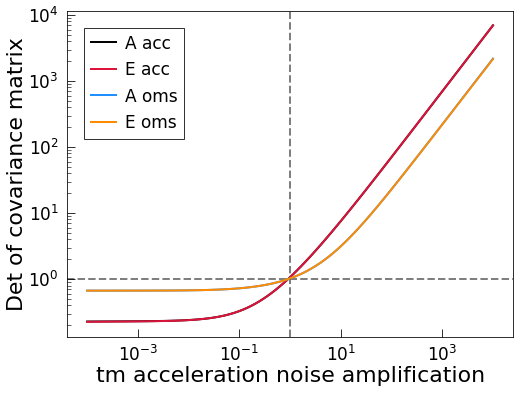

In [14]:
det_cov_totn = np.zeros(det_cov_tot.shape)
for i in range(4):
    det_cov_totn[i] = det_cov_tot[i]/(det_cov_tot[i][index_closest_to1])

plt.figure(figsize=(8,6))
plt.axvline(1,c='black',linestyle='--',alpha=.5)
plt.axhline(1,c='black',linestyle='--',alpha=.5)
for i,chan in enumerate(lab):
    plt.loglog(alpha,(det_cov_totn[i])**(1/16),label=chan)
plt.xlabel("tm acceleration noise amplification")
plt.ylabel("Det of covariance matrix")
plt.legend()
plt.show()

In [15]:
# Calculate the diagnoal of the inverse fisher matrix (so covariance matrix) s.t. you get the deltas of each galbin Amplitude
cov_matrix_diag = np.zeros((4,len(alpha),Ngalbins))
for a,alph in enumerate(tqdm(alpha)):
    for i in range(4):
        cov_matrix_diag[i][a] = 1/np.sqrt(np.diag(reduction_factor*fishermatrices[i][a]))


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 22777.80it/s]


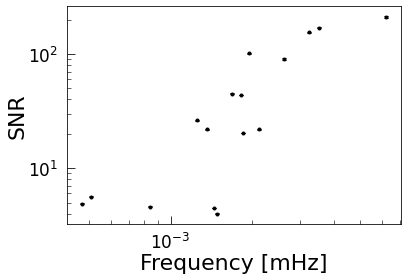

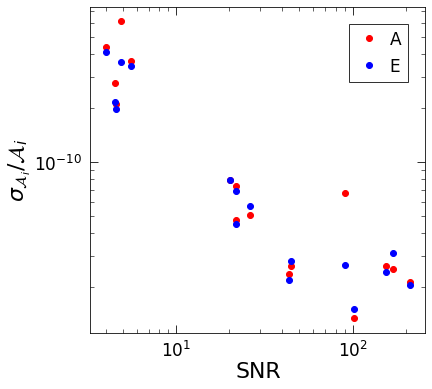

In [16]:
# Plot \sigma_A/A for each binary as function of SNR
plt.figure(figsize=(6,4))
plt.errorbar(f_true,SNR_verbins,yerr=SNRe_verbins,fmt='.')
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Frequency [mHz]")
plt.ylabel("SNR")
plt.show()

plt.figure(figsize=(6,6))
for i,l in enumerate(rec):
    plt.errorbar(SNR_verbins,cov_matrix_diag[i][index_closest_to1]/Amp_true,fmt='o',c=['red','blue'][i],label=l)
plt.xscale('log'); plt.yscale('log')
plt.ylabel("$\sigma_{\mathcal{A}_i}/\mathcal{A}_i$")
plt.xlabel("SNR")
# plt.title("$\sigma_{A_i}/A_i$ vs SNR")
plt.legend()
# plt.grid()
plt.tick_params(axis='both',which='both',top=True,right=True)
plt.savefig('plots/sigma_SNR_{}d.pdf'.format(duration//day))
plt.show()

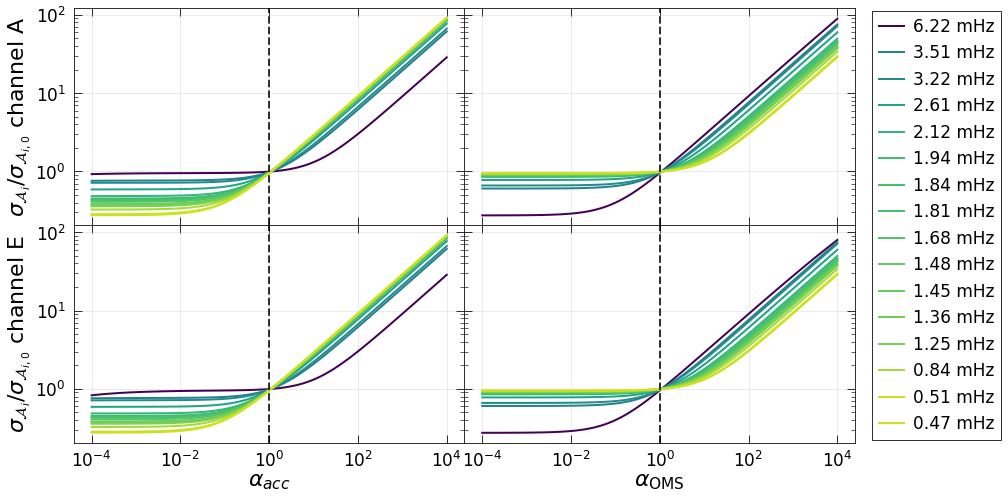

In [17]:
import matplotlib.pylab as pl

sorted_galbins = np.argsort(f_true)[::-1]

def gb_influplot(a,data,title,N,axs,i,j,skip=1,label=False):
    for k in sorted_galbins[::skip]:
        axs[i,j].loglog(a,data[:,k],label="{:.2f} mHz".format(f_true[k]*1e3),c=pl.cm.viridis(1-f_true[k]/f_true[0]))
        #c=times/1e9,cmap='jet'
    # Enable title to see what is plotted
    # axs[i,j].set_title(title)
    axs[i,j].axvline(1,c='black',linestyle='--',alpha=0.8)
    axs[i,j].grid()
    axs[i,j].tick_params(axis='both',which='both',top=True,right=True)
    # axs[i,j].axhline(1,c='black',linestyle='--',alpha=.5)
    if i == 1:
        if j == 0:
            axs[i,j].set_xlabel("$\\alpha_{acc}$")
        else:
            axs[i,j].set_xlabel("$\\alpha_{\mathrm{OMS}}$")
            axs[i,j].legend(bbox_to_anchor=(1,1),loc='center left')
        axs[i,j].set_xticks(np.logspace(-4,4,5))
        
        
    if j == 0:
        axs[i,j].set_ylabel("$\sigma_{\mathcal{A}_i}/\sigma_{\mathcal{A}_{i,0}}$ channel "+rec[i])
    if label:
        axs[i,j].legend()

fig,axs = plt.subplots(2,2,figsize=(14,8),sharex=True,sharey=True,gridspec_kw={"hspace":0,"wspace":0})
for i,l,x,y in zip(range(4),lab,[0,1,0,1], [0,0,1,1]):
    gb_influplot(alpha,cov_matrix_diag[i]/cov_matrix_diag[i,len(alpha)//2],l,Ngalbins,axs,x,y)
    # gb_influplot(alpha,cov_matrix_diag[i]/cov_matrix_diag[i,0],l,Ngalbins,axs,x,y)
plt.savefig("plots/sigma_alpha.pdf")
plt.show()


In [18]:
# Calculate at which alpha the binary amplitude error doubles for acc and oms
d_index = np.zeros((4,Ngalbins),dtype=int)
N3 = 10001
alph_extended = np.logspace(-4,4,N3)
interp_values = np.zeros((4,N3,Ngalbins))
for i in range(4):
    for j in range(Ngalbins):
        interp_values[i,:,j] = np.interp(alph_extended,alpha,cov_matrix_diag[i,:,j])
        arr = abs(interp_values[i,:,j]-2*interp_values[i,N3//2,j])
        # i_tmp = np.where(abs(alpha-1e-3) == np.min(abs(alpha-1e-3)))[0][0]
        # arr = abs(cov_matrix_diag[i,:,j]-2*cov_matrix_diag[i,i_tmp,j])
        # arr = abs(cov_matrix_diag[i,:,j]-2*cov_matrix_diag[i,0,j])
        d_index[i][j] = np.where(arr == np.min(arr))[0][0]

d_value = np.zeros((4,Ngalbins))
for i in range(4):
    for j in range(Ngalbins):
        d_value[i][j] = alph_extended[d_index[i][j]]

[1.       1.71875  1.671875 0.96875  4.421875 0.953125 2.734375 0.5
 0.65625  2.09375  2.5      2.53125  4.671875 1.796875 4.125    6.484375]


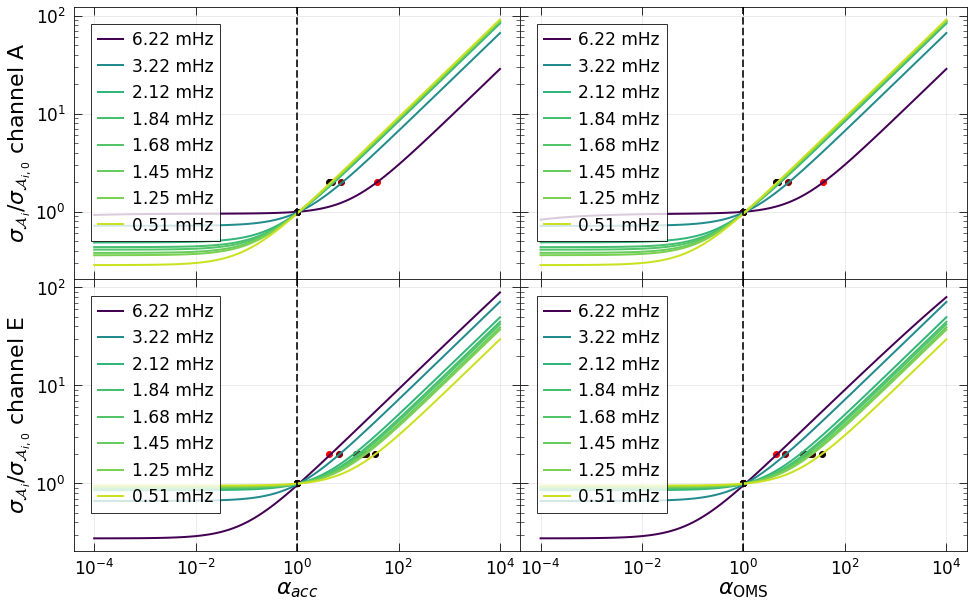

In [19]:
# Plot the results
# n = Ngalbins #limit range for better visuals
amp_normfac = Amp_true/Amp_true[0]
print (amp_normfac)

n = 16
skip = 2

fig,axs = plt.subplots(2,2,figsize=(16,10),sharex=True,sharey=True,gridspec_kw={'hspace':0,'wspace':0})
for i,l,x,y in zip(range(4),lab,[0,0,1,1], [0,1]*2):
    gb_influplot(alpha,cov_matrix_diag[i]/cov_matrix_diag[i,len(alpha)//2],l,n,axs,x,y,skip,True)
    
    for j in range(Ngalbins)[:n:skip]:
        axs[x,y].scatter([1,d_value[i][j]],np.array([interp_values[i,N3//2,j],interp_values[i,d_index[i,j],j]])/interp_values[i,N3//2,j],color=(f_true[j]/f_true[0],0,0))

plt.savefig('Precisionloss_v_noise-amp.jpg')
plt.show()


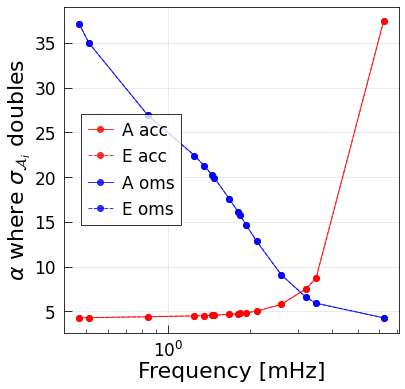

In [29]:
colors = ['red','indianred', 'blue', 'royalblue']

plt.figure(figsize=(6,6))
for i,l in enumerate(lab):
    plt.plot(1e3*f_true[sorted_galbins],d_value[i][sorted_galbins],label=l,c=cols[i],linestyle=lnstls[i],marker='o',alpha=.8,linewidth=1)
plt.xscale('log')
# plt.yscale('log')
# plt.legend(loc="center right")
plt.legend(loc=6)
plt.xlabel("Frequency [mHz]")
plt.ylabel("$\\alpha$ where $\sigma_{\mathcal{A}_i}$ doubles")
# plt.title("VB's to sample acceleration and OMS noise")
# plt.xlim(4e-1,1e1)
# plt.ylim(1,41)
# plt.yticks([4e0,1e1,4e1])
plt.grid()

plt.savefig("plots/sigdouble_freq.pdf")
plt.show()

filecontent = Table(d_value.T,names=lab)
filename = 'sigdouble_semianalytical_results.txt'
ascii.write(filecontent,filename,overwrite=True)

In [21]:
# Look why A and E are different for several binaries
# tmp = np.min(mdatas[0,0]/day) + np.linspace(0,0.1,2)

# # for b in [0,1,2,7]:
# for b in range(Ngalbins):
#     for mi,ma in zip(tmp[:-1],tmp[1:]):
#         # avg = (sdata[i+1][1:]+sdata[i+1][:-1])/2
#         plt.figure(figsize=(16,6))
#         plt.plot(mdatas[b,0]/day,mdatas[b,1],label="A")
#         plt.plot(mdatas[b,0]/day,mdatas[b,2],label="E")
#         plt.title("Binary {}".format(b+1))
#         plt.legend()
#         plt.xlabel('Time (hrs)')
#         plt.ylabel('Amplitude')
#         plt.xlim(mi,ma)
#         plt.show()\

# No idea...

In [22]:
# plt.scatter(Amp_true,(np.log(d_value[0]/d_value[2])))
# plt.axhline(0,c='black')
# plt.grid()
# plt.show()
# plt.scatter(f_true,Amp_true)
# # plt.xscale('log'); plt.yscale('log')

### Calcluate correlation matrices from fisher matrices

In [23]:
for l in lab:
    print (l)
print (fishermatrices.shape)
print (index_closest_to1)

A acc
E acc
A oms
E oms
(4, 100, 16, 16)
49


0.9999988007325921


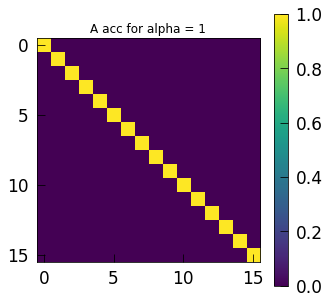

0.9999987674695061


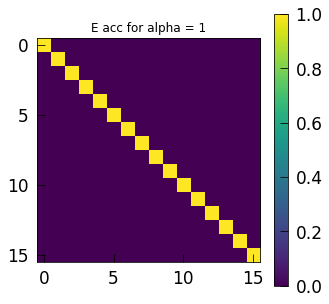

0.9999988680635952


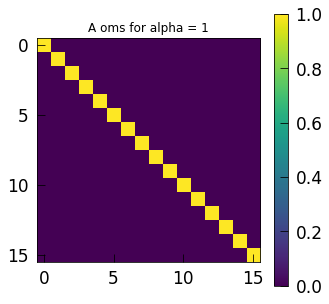

0.9999989297473995


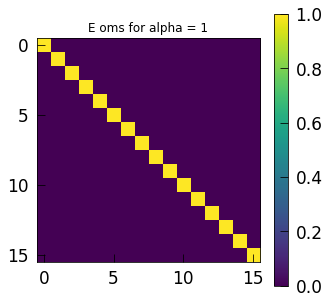

In [24]:
corr_matrix = np.zeros((len(alpha),4,16,16))
for i in range(len(alpha)):
    for x in range(4):
        delta = np.sqrt(np.diagonal(fishermatrices[x,i]))
        for j in range(Ngalbins):
            for k in range(Ngalbins):
                corr_matrix[i,x,j,k] = fishermatrices[x,i,j,k]/(delta[j]*delta[k])
for x,l in enumerate(lab):
    print (np.linalg.det(corr_matrix[index_closest_to1,x]))
    plt.figure(figsize=(5,5))
    plt.imshow(corr_matrix[index_closest_to1,x])
    plt.colorbar()
    plt.title(l+" for alpha = 1")
    plt.show()

In [25]:
cols = ['red','red','blue','blue']
lnstls = ['-','--','-','--']

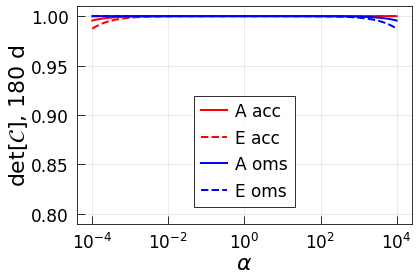

In [26]:
plt.figure(figsize=(6,4))
for x,l in enumerate(lab):
    lst = np.zeros(len(alpha))
    for i in range(len(alpha)):
        lst[i] = np.linalg.det(corr_matrix[i,x])
    plt.semilogx(alpha,lst,label=l,c=cols[x],linestyle=lnstls[x])
plt.legend(loc="lower center")
plt.ylim(0.79,1.01)
plt.xlabel("$ \\alpha $")
plt.xticks(np.logspace(-4,4,5))
plt.ylabel("det[$\mathcal{C}$], "+str(duration//day)+" d")
plt.grid()
# plt.title("Det of correlation matrix as function of alpha for {} d".format(duration//day))
plt.savefig("plots/Detcormatrix_{}d.pdf".format(duration//day))
plt.show()

Determinant of plot below = 0.99557


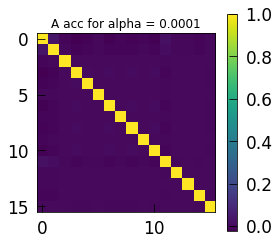

Determinant of plot below = 0.98736


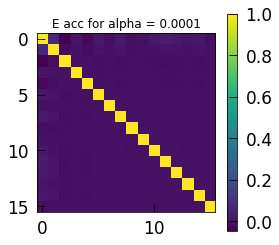

Determinant of plot below = 1.00000


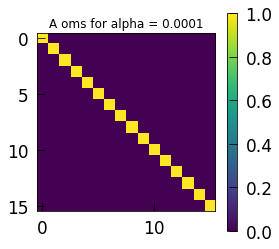

Determinant of plot below = 1.00000


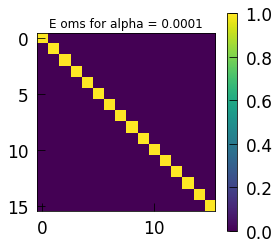

Determinant of plot below = 1.00000


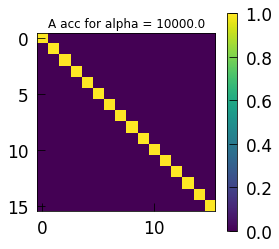

Determinant of plot below = 1.00000


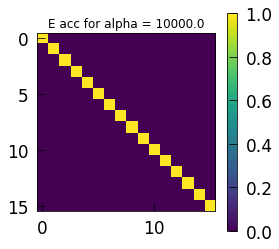

Determinant of plot below = 0.99557


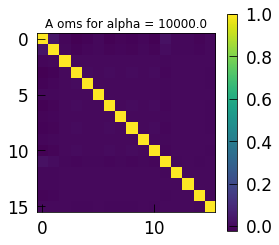

Determinant of plot below = 0.98736


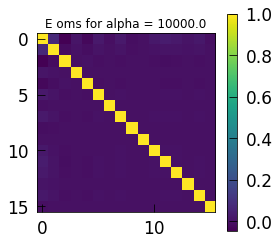

In [27]:
for i in [0,len(alpha)-1]:
    alph = alpha[i]
    for x,l in enumerate(lab):
        plt.figure(figsize=(4,4))
        print ("Determinant of plot below = {:.5f}".format(np.linalg.det(corr_matrix[i,x])))
        plt.imshow(corr_matrix[i,x])
        plt.colorbar()
        plt.title("{} for alpha = {}".format(l,alph))
        plt.show()